In [1]:
import math
import random
from random import randint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import IPython as ip

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import yacht_main as yacht
from yacht_test import create_train_set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class Reshape(torch.nn.Module):
    """def __init__(self, size):
        super(Reshape, self).__init__()
        self.input_size = size"""
    def forward(self, x, *args):
        return x.view(args)

class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.isize = input_size
        self.dice1 = nn.Linear(input_size, 200)
        self.dice2 = nn.Linear(200, 100)
        self.dice3 = nn.Linear(100, 50)
        
        self.diceconv = nn.Conv2d(1, 300, (1, input_size))
        self.convshape = Reshape()
        #self.dice4 = nn.Linear(100, 100)
        #self.dice5 = nn.Linear(100, 100)
        #self.dice6 = nn.Linear(100, 100)
        self.dice7 = nn.Linear(50, output_size)
        #self.score1 = nn.Linear(12, 12)
        
        
    def forward(self, x):
        #x = self.convshape(x, -1, 1, 1, self.isize)
        #x = self.diceconv(x)
        #x = self.convshape(x, -1, 300)
        x = torch.sigmoid(self.dice1(x))
        x = torch.sigmoid(self.dice2(x))
        x = torch.sigmoid(self.dice3(x))
        #x = torch.sigmoid(self.dice4(x))
        #x = torch.sigmoid(self.dice5(x))
        #x = torch.sigmoid(self.dice6(x))
        x = self.dice7(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m,0.1)

In [4]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000000
steps_done = 0
INPUT_SIZE = 1
OUTPUT_SIZE = 1
TARGET_UPDATE = 20
TRAINSET_UPDATE = 1000
policy_net = None
target_net = None

def select_action(state, avail):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    """
    if sample > eps_threshold:
        with torch.no_grad():
            policy_net(state)
            return (policy_net(state) * avail).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(OUTPUT_SIZE)]], device=device, dtype=torch.long)
    """
    if sample <= eps_threshold:
        random_action = 0
        randomizer = randint(1, avail.sum())
        avail_list = torch.reshape(avail,[-1]).tolist()
        for i in range(len(avail_list)):
            if avail_list[i] == 1:
                if randomizer == 1:
                    random_action = i
                    break
                randomizer -= 1
        return torch.tensor([[random_action]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            a = policy_net(state)
            #a -= a.min()
            return a.max(1)[1].view(1, 1)


episode_scores = []
episode_success = []
episode_reward = []

def plot_scores():
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    success_t = torch.tensor(episode_success, dtype=torch.float)
    reward_t = torch.tensor(episode_reward, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy())
    if len(scores_t) >= 50:
        means = scores_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())
    if len(success_t) >= 50:
        sucm = success_t.unfold(0, 50, 1).mean(1).view(-1)
        sucm = torch.cat((torch.zeros(49), sucm))
        plt.plot(sucm.numpy())
    if len(reward_t) >= 50:
        rewm = reward_t.unfold(0, 50, 1).mean(1).view(-1)
        rewm = torch.cat((torch.zeros(49), rewm))
        plt.plot(rewm.numpy())

    ip.display.clear_output(wait=True)
    plt.pause(0.001)

In [5]:
def init_net(isize, osize, msize):
    global policy_net, target_net, optimizer, memory, EPS_START, EPS_END, EPS_DECAY, steps_done, episode_scores
    global TARGET_UPDATE, INPUT_SIZE, OUTPUT_SIZE
    INPUT_SIZE = isize
    OUTPUT_SIZE = osize

    MEMORY_SIZE = msize

    TARGET_UPDATE = 5

    memory = ReplayMemory(MEMORY_SIZE)

    policy_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
    target_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)

    #init_weights(policy_net)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 500
    steps_done = 0

    episode_scores = []

In [6]:
BATCH_SIZE = 8
GAMMA = 0
reward_rate = 0.1
regul = 0


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1)) + torch.norm(policy_net(state_batch)) * regul
    print('state ex: ' + str(state_batch[0]))
    print('action:' + str(action_batch.view(-1)))
    print('reward:' + str(reward_batch.view(-1)))
    print('value:' + str(state_action_values.view(-1)))
    print('expected:' + str(expected_state_action_values.unsqueeze(1).view(-1)))

    
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    print('after:' + str(state_action_values.view(-1)))
    print('\n')
    

In [7]:
def add_trainset():
    print("Creating train set...")
    train_set_size = 3000 // 5
    train_set = create_train_set(train_set_size)
    for state, action, new_state, step_reward in train_set:
        state_tensor = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        action_tensor = torch.tensor([[action - 31]], device=device, dtype=torch.long)
        new_state_tensor = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
        step_reward_tensor = torch.tensor([step_reward], device=device, requires_grad = False)
        memory.push(state_tensor.reshape(1,INPUT_SIZE), action_tensor, new_state_tensor.reshape(1,INPUT_SIZE), step_reward_tensor)
    print("Created", train_set_size * 5, "train set")

In [8]:
def net1_main():
    global episode_scores, episode_success, episode_reward
    init_net(12, 12, 10000)

    num_episodes = 1000000
    made_prob = 0.9
    episode_scores = []
    episode_success = []
    episode_reward = []

    for i_episode in range(num_episodes):
        reward_total = 0
        yacht.reset_game()
        state, score, _, avail = yacht.get_yacht_output()
        state = torch.tensor(state[:12], dtype=torch.float, device=device, requires_grad = False)
        for t in count():
            avail = avail[31:]
            avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
            action = select_action(state.reshape(1,INPUT_SIZE), avail) + 31
            reward = yacht.update(action)
            if reward != -1:
                reward_total+=reward

            new_state, _, done, avail = yacht.get_yacht_output()
            step_reward = torch.tensor([reward], device=device, requires_grad = False)
            
            #print(str(action) + ' ' + str(reward) + ' ' + str(yacht.dice_status))
            
            if random.random() < made_prob:
                yacht.handled_roll()

            if not done:
                new_state = torch.tensor(new_state[:12], dtype=torch.float, device=device, requires_grad = False)
                memory.push(state.reshape(1,INPUT_SIZE), action - 31, new_state.reshape(1,INPUT_SIZE), \
                        step_reward)
            else:
                new_state = None
                memory.push(state.reshape(1,INPUT_SIZE), action - 31, None, \
                        step_reward)

            state = new_state

            optimize_model()
            if done:
                state, score, _, _ = yacht.get_yacht_output()
                episode_success.append(state[:12].count(-1) * 10)
                episode_scores.append(score)
                episode_reward.append(reward_total)
                
                #print("{0}) {1}\tscore : {2}, turns = {3}".format(i_episode, state[:12], score, t+1))

                if i_episode % 200 == 0:
                    plot_scores()

                break
        #if i_episode % TRAINSET_UPDATE == 0:
        #    add_trainset()
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 10000 == 0:
            torch.save(policy_net.state_dict(), './data/net1/net_' + str(i_episode//10000))

    print('Complete')

In [9]:
def net2_main(net1_name):
    global episode_scores, episode_success
    init_net(20, 32, 3000)
    
    reward_net = DQN(20, 12).to(device)
    reward_net.load_state_dict(torch.load('./data/net1/' + net1_name))
    reward_net.eval()
    reward_net.requires_grad = False
    
    num_episodes = 500000
    made_prob = 0.66
    episode_scores = []

    for i_episode in range(num_episodes):
        yacht.reset_game()
        state, score, _, avail = yacht.get_yacht_output()
        state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        for t in count():
            avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
            action = select_action(state.reshape(1,INPUT_SIZE), avail)
            
            if action >= 31:
                a = policy_net(state)
                a -= a.min()
                action = (a * avail[31:]).max(1)[1].view(1, 1)
            yacht.update(action)

            new_state, _, done, avail = yacht.get_yacht_output()
            step_reward = reward_net(state).max(1)[0]


            if not done:
                new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                memory.push(state.reshape(1,INPUT_SIZE), action, new_state.reshape(1,INPUT_SIZE), \
                        step_reward)
            else:
                new_state = None
                memory.push(state.reshape(1,INPUT_SIZE), action, None, \
                        step_reward)

            state = new_state

            optimize_model()
            if done:
                state, score, _, _ = yacht.get_yacht_output()
                episode_scores.append(score)
                if i_episode % 200 == 0:
                    plot_scores()

                break

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 10000 == 0:
            torch.save(policy_net.state_dict(), './data/net2/net_' + str(i_episode//10000))

    print('Complete')

In [10]:
def net3_main():
    global episode_scores, episode_success
    init_net(45, 43, 10000)
    
    num_episodes = 50000
    num_average = 5
    num_optimize = 50
    episode_scores = []
    episode_success = []
    
    for i_episode in range(num_episodes):
        
        episode_memory = []
        episode_total = 0
        episode_suctotal = 0
        for i_average in range(num_average):
            yacht.reset_game()
            state, score, _, avail = yacht.get_yacht_output()
            state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
            for t in count():
                avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
                action = select_action(state.reshape(1,INPUT_SIZE), avail)

                reward = yacht.update(action)
                reward = torch.tensor([reward], device=device, requires_grad = False)

                new_state, _, done, avail = yacht.get_yacht_output()

                if not done:
                    new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                    episode_memory.append(Transition(state.reshape(1,INPUT_SIZE), action, new_state.reshape(1,INPUT_SIZE), \
                            0))
                    state = new_state
                else:
                    new_state = None
                    if reward == -10:
                        memory.push(state.reshape(1,INPUT_SIZE), action, None, reward)
                    else:
                        episode_memory.append(Transition(state.reshape(1,INPUT_SIZE), action, None, 0))                
                    state, score, _, _ = yacht.get_yacht_output()
                    episode_suctotal += state[:12].count(-1) * 10
                    episode_total += score
                    break;
        
        average_reward = episode_total / len(episode_memory)
        average_reward = torch.tensor([average_reward], device=device, requires_grad = False)
        for x in episode_memory:
            memory.push(x.state, x.action, x.next_state, average_reward)
        
        for i_average in range(num_optimize):
            optimize_model()
        
        
        episode_success.append(episode_suctotal/num_average)
        episode_scores.append(episode_total/num_average)
        if i_episode % 50 == 0:
            plot_scores()
        #if i_episode % TARGET_UPDATE == 0:
        #    target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 1000 == 0:
            torch.save(policy_net.state_dict(), './data/net3/net_' + str(i_episode//1000))

    print('Complete')

In [11]:
def net4_main():
    global episode_scores, episode_success
    init_net(12, 12, 10000)
    
    num_episodes = 50000
    num_average = 5
    num_optimize = 50
    made_prob = 0.85
    episode_scores = []
    episode_success = []
    
    for i_episode in range(num_episodes):
        
        episode_memory = []
        episode_total = 0
        episode_suctotal = 0
        for i_average in range(num_average):
            
            yacht.reset_game()
            state, score, _, avail = yacht.get_yacht_output()
            state = torch.tensor(state[:12], dtype=torch.float, device=device, requires_grad = False)
            for t in count():
                avail = avail[31:]
                avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
                action = select_action(state.reshape(1,INPUT_SIZE), avail) + 31
                reward = yacht.update(action)
                reward = torch.tensor([reward], device=device, requires_grad = False)

                new_state, _, done, avail = yacht.get_yacht_output()
                new_state = new_state[:12]

                if random.random() < made_prob:
                    yacht.handled_roll()       
                
                if not done:
                    new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                    episode_memory.append(Transition(state.reshape(1,INPUT_SIZE), action - 31, new_state.reshape(1,INPUT_SIZE), \
                            0))
                    state = new_state
                else:
                    new_state = None
                    if reward == -10:
                        memory.push(state.reshape(1,INPUT_SIZE), action - 31, None, reward)
                    else:
                        episode_memory.append(Transition(state.reshape(1,INPUT_SIZE), action - 31, None, 0))                
                    state, score, _, _ = yacht.get_yacht_output()
                    episode_suctotal += state[:12].count(-1) * 10
                    episode_total += score
                    break;
        
        average_reward = episode_total / len(episode_memory)
        average_reward = torch.tensor([average_reward], device=device, requires_grad = False)
        for x in episode_memory:
            memory.push(x.state, x.action, x.next_state, average_reward)
        
        for i_average in range(num_optimize):
            optimize_model()
        
        
        episode_success.append(episode_suctotal/num_average)
        episode_scores.append(episode_total/num_average)
        if i_episode % 50 == 0:
            plot_scores()
        #if i_episode % TARGET_UPDATE == 0:
        #    target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 1000 == 0:
            torch.save(policy_net.state_dict(), './data/net4/net_' + str(i_episode//1000))

    print('Complete')

In [12]:
net1 = DQN(20, 12)
net2 = DQN(20, 32)
def duel_action(state):
    action = net2(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1]

    if action == 31:
        action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1]
    return action

In [13]:
def test_model(net1r,net2r):
    net1 = DQN(20, 12)
    net1.load_state_dict(torch.load('./data/net1/' + net1r))
    net1.eval()
    net2 = DQN(20, 32)
    net2.load_state_dict(torch.load('./data/net2/' + net2r))
    net2.eval()
    
    yacht.reset_game()
    done = False
    while not done :
        state,reward,done,_ = yacht.get_yacht_output()
        print(state)
        action = duel_action(state)
        yacht.update(action)
        print(action)

In [14]:
def test_net1(net1r):
    net1 = DQN(20, 12)
    net1.load_state_dict(torch.load('./data/net1/' + net1r))
    net1.eval()
    
    yacht.reset_game()
    done = False
    while not done :
        yacht.handled_roll()
        state,reward,done,_ = yacht.get_yacht_output()
        print(state)
        action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1] + 31
        yacht.update(action)
        print(action)

In [15]:
#net4_main()

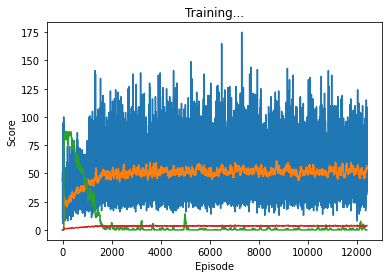

state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0., -10., -10., -10., -10.],
       device='cuda:0')
action:tensor([ 7,  8, 11, 11,  5,  1, 10,  5], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.5000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.0885, 0.0792, 0.2464, 0.2285, 0.2410, 0.3875, 0.0565, 0.2410],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.5000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.0886, 0.0799, 0.2460, 0.2282, 0.2418, 0.3870, 0.0572, 0.2418],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([9, 6, 3, 1, 1, 9, 4, 7], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.5000, 0.0000, 0.0000, 1.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.2532, 0.7351, 0.5313, 0.3380, 0.3777, 0.2532, 0.3156, 0.0886],

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   2., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1,  1,  4, 11, 10, 10,  8,  9], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3106, 0.3230, 0.2723, 0.3024, 0.0566, 0.0576, 0.1128, 0.3270],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3091, 0.3216, 0.2737, 0.3031, 0.0562, 0.0572, 0.1165, 0.3267],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   4., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1,  4,  7, 10,  4,  8,  7,  3], device='cuda:0')
reward:tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
value:tensor([0.3951, 0.3110, 0.0934, 0.1719, 0.3713, 0.1156, 0.081

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2.,   0., -10.,  10.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([4, 7, 1, 4, 7, 6, 3, 5], device='cuda:0')
reward:tensor([ 0.5000,  0.0000,  1.0000,  0.5000,  0.0000,  0.5000, -1.0000,  0.5000],
       device='cuda:0')
value:tensor([0.3080, 0.1023, 0.8342, 0.3024, 0.1023, 0.5356, 0.1832, 0.1831],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([ 0.5000,  0.0000,  1.0000,  0.5000,  0.0000,  0.5000, -1.0000,  0.5000],
       device='cuda:0')
after:tensor([0.3085, 0.1033, 0.8335, 0.3030, 0.1033, 0.5336, 0.1814, 0.1842],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   4.,   0.,   0.,   5.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3,  2,  2, 11,  9,  5,  0,  2], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 0.5000, 0.5000, 1.5000],
       device='cuda:0')
value:tensor

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 8,  7, 11, 10,  6, 11,  1,  3], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.2000, 0.0000, 0.5000, 0.2000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.1212, 0.1150, 0.2042, 0.1684, 0.5153, 0.2186, 0.2609, 0.2051],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.2000, 0.0000, 0.5000, 0.2000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.1208, 0.1149, 0.2037, 0.1676, 0.5141, 0.2181, 0.2606, 0.2050],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([7, 9, 0, 2, 1, 1, 5, 2], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.5000, 1.0000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.1149, 0.2269

action:tensor([3, 0, 2, 6, 9, 9, 4, 5], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3006, 0.4926, 0.3215, 0.5846, 0.2720, 0.2320, 0.3304, 0.2243],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3014, 0.4913, 0.3218, 0.5869, 0.2734, 0.2336, 0.3296, 0.2235],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   6., -10., -10., -10.,   0., -10.,   0., -10.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([1, 6, 3, 9, 1, 0, 0, 6], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.4200, 0.4158, 0.3287, 0.9960, 0.2933, 0.3520, 0.2310, 0.6667],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 0.5000, 0.0000, 0

       device='cuda:0')
value:tensor([0.2294, 0.2834, 0.4327, 0.3338, 0.3136, 0.3748, 0.4273, 0.0915],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.2000, 0.5000, 1.0000, 1.0000],
       device='cuda:0')
after:tensor([0.2288, 0.2822, 0.4324, 0.3339, 0.3155, 0.3754, 0.4279, 0.0925],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   0., -10., -10., -10.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1,  9,  5, 11, 10,  5,  2,  0], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 1.5000, 0.5000],
       device='cuda:0')
value:tensor([0.2831, 0.3059, 0.2008, 0.3155, 0.0647, 0.2655, 0.3157, 0.3117],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 1.5000, 0.5000],
       device='cuda:0')
after:tensor([0.2834, 0.3071, 0.1998, 0.3172, 0.0652, 0.2644, 0.3182, 0.3112],
       device='cud

       device='cuda:0')
action:tensor([0, 4, 7, 8, 3, 1, 2, 8], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.5949, 0.2671, 0.1053, 0.1151, 0.3308, 0.3875, 0.4000, 0.0960],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.5931, 0.2671, 0.1060, 0.1164, 0.3315, 0.3868, 0.3996, 0.0973],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 1.,  4.,  3.,  4.,  0.,  0., 12.,  0.,  0., 15.,  0.,  0.],
       device='cuda:0')
action:tensor([ 9,  2,  8,  3,  9,  5,  5, 10], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([1.0646, 0.2637, 0.1162, 0.1991, 0.1597, 0.2191, 0.2287, 0.0606],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0.5000, 0.000

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.2000],
       device='cuda:0')
after:tensor([0.0987, 0.1282, 0.2817, 0.2960, 0.2666, 0.2663, 0.2479, 0.3637],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10., -10.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 5,  1, 11, 11, 11,  6,  1,  8], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.2000, 0.2000, 0.2000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2467, 0.2565, 0.3389, 0.3186, 0.3896, 0.5967, 0.2217, 0.1282],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.2000, 0.2000, 0.2000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2470, 0.2559, 0.3399, 0.3200, 0.3908, 0.5982, 0.2210, 0.1281],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10.,   6., -10., -10.,   6., -10.,   0.,   0.,

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 1.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.3216, 0.2786, 0.3419, 0.2781, 0.1166, 0.6312, 0.3145, 0.2526],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([9, 0, 7, 9, 5, 4, 3, 3], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.2697, 0.3257, 0.0984, 0.3821, 0.2853, 0.3307, 0.3954, 0.3289],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.2697, 0.3251, 0.0991, 0.3821, 0.2844, 0.3321, 0.3961, 0.3297],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   2., -10., -10.,   5.,   6., -10.,   0.,   0.,   0.,  

       device='cuda:0')
action:tensor([ 6,  2,  6,  9, 11,  2, 10,  0], device='cuda:0')
reward:tensor([1.0000, 0.5000, 1.0000, 0.0000, 0.2000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.5437, 0.2620, 0.8552, 0.2647, 0.3668, 0.3945, 0.1932, 0.2543],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.5000, 1.0000, 0.0000, 0.2000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
after:tensor([0.5467, 0.2640, 0.8579, 0.2655, 0.3665, 0.3955, 0.1944, 0.2564],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  2.,   0., -10., -10.,   0., -10., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1,  1,  5,  3,  4,  7,  7, 10], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2105, 0.3376, 0.2089, 0.3758, 0.3179, 0.0974, 0.0933, 0.0970],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0

       device='cuda:0')
action:tensor([6, 7, 9, 0, 9, 4, 0, 9], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.6710, 0.0962, 0.2651, 0.1830, 0.2651, 0.3795, 0.5295, 0.2315],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.6730, 0.0958, 0.2640, 0.1835, 0.2640, 0.3802, 0.5296, 0.2304],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  2., -10.,   9., -10., -10.,   0., -10.,   0.,  11., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 2,  7,  5, 11,  3,  9,  4,  7], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.4349, 0.0958, 0.2472, 0.3545, 0.3444, 0.2711, 0.2964, 0.1065],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 1.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.5000, 0.2000],
       device='cuda:0')
after:tensor([0.3776, 1.0646, 0.3432, 0.3499, 0.5824, 0.2710, 0.3835, 0.3025],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([10,  8,  7,  0,  6,  2,  6,  6], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000],
       device='cuda:0')
value:tensor([0.0923, 0.1351, 0.0942, 0.1976, 0.6883, 0.4034, 0.5371, 0.7350],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000],
       device='cuda:0')
after:tensor([0.0913, 0.1342, 0.0934, 0.1976, 0.6869, 0.4041, 0.5349, 0.7344],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10., -10.,   0., -10.,   0.,   0.,

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.5000, 0.2000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3322, 0.6345, 0.2588, 0.3028, 0.0721, 0.5748, 0.3451, 0.1986],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   2., -10.,   4., -10.,  12., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3, 11,  4,  7,  0,  0,  6,  9], device='cuda:0')
reward:tensor([0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.4344, 0.2907, 0.3298, 0.0721, 0.2370, 0.3191, 0.6036, 0.2476],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.4334, 0.2897, 0.3301, 0.0713, 0.2358, 0.3184, 0.6013, 0.2462],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,

       device='cuda:0')
after:tensor([0.3076, 0.9318, 0.3051, 0.4224, 0.3257, 0.6236, 0.3856, 0.0582],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10., -10.,   0., -10.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([11,  3,  4,  2,  5,  3, 11,  4], device='cuda:0')
reward:tensor([0.2000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.1965, 0.5737, 0.2934, 0.4071, 0.2321, 0.4185, 0.2399, 0.2696],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
after:tensor([0.1983, 0.5725, 0.2920, 0.4078, 0.2329, 0.4188, 0.2417, 0.2682],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([10, 11,  8,  1,  1, 10,  5, 11], device='cuda:0')
reward:tensor([1.0000

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.2000, 0.5000, 0.0000, 0.2000, 1.0000, 0.5000, 1.5000],
       device='cuda:0')
after:tensor([0.2808, 0.2557, 0.2651, 0.0835, 0.2450, 0.1917, 0.2933, 0.4172],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   6., -10.,   0.,   5.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([3, 1, 6, 2, 4, 5, 6, 8], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.3828, 0.3817, 0.6475, 0.4593, 0.2585, 0.2448, 0.5964, 0.0452],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.3830, 0.3830, 0.6468, 0.4599, 0.2579, 0.2458, 0.5958, 0.0458],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  3.,   0., -10., -10.,   0.,   6., -10.,   0.,   0.,   0.,  

       device='cuda:0')
value:tensor([0.2926, 0.0802, 0.0779, 0.0824, 0.2583, 0.2105, 0.3931, 0.2105],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2926, 0.0807, 0.0771, 0.0828, 0.2590, 0.2093, 0.3931, 0.2093],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([ 9,  3,  1,  9,  3,  6, 11,  5], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.2028, 0.5122, 0.3274, 0.2028, 0.4439, 0.6037, 0.3118, 0.3306],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
after:tensor([0.2011, 0.5122, 0.3267, 0.2011, 0.4440, 0.6021, 0.3110, 0.3305],
       device='cud

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.1023, 0.0716, 0.2729, 0.1025, 0.0716, 0.4312, 0.2959, 0.1778],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10., -10., -10.],
       device='cuda:0')
action:tensor([ 7,  4, 11,  1,  8,  6,  0,  7], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.0873, 0.2512, 0.5323, 0.2877, 0.0716, 0.6198, 0.2207, 0.1140],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 1.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.0866, 0.2530, 0.5312, 0.2868, 0.0703, 0.6164, 0.2214, 0.1134],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,

action:tensor([7, 0, 4, 9, 9, 1, 8, 0], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.0987, 0.2554, 0.2955, 0.2848, 0.1494, 0.3572, 0.0631, 0.3006],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.0998, 0.2543, 0.2954, 0.2841, 0.1492, 0.3584, 0.0632, 0.2995],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2., -10.,   8.,   5.,   0.,  16.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 6,  0,  0,  8, 11,  7,  8, 11], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.2000, 0.5000, 0.0000, 0.2000],
       device='cuda:0')
value:tensor([0.5679, 0.2094, 0.2482, 0.0569, 0.2980, 0.0879, 0.0569, 0.2495],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.2000, 0.5000, 0

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,  30., -10.],
       device='cuda:0')
action:tensor([10,  3,  4, 10,  1,  6, 10,  2], device='cuda:0')
reward:tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
value:tensor([0.1961, 0.3853, 0.2538, 0.1018, 0.3164, 0.3773, 0.1016, 0.4306],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
after:tensor([0.1963, 0.3836, 0.2526, 0.1021, 0.3154, 0.3753, 0.1020, 0.4296],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10., -10.,   6., -10.,   0., -10., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([5, 8, 6, 5, 5, 0, 3, 5], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 1.5000],
       device='cuda:0')
value:tensor([0.2744, 0.0689, 0.5285, 0.2247, 0.2836, 0.2597, 0.3996, 0.2302],
       device='cuda:0', grad_fn=<Vi

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2., -10.,   8.,   0.,   6.,  17.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 6,  9, 10,  2, 10,  2,  0,  2], device='cuda:0')
reward:tensor([0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.5966, 0.2714, 0.1916, 0.4223, 0.0982, 0.3738, 0.2891, 0.2980],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.5958, 0.2722, 0.1905, 0.4220, 0.0970, 0.3733, 0.2887, 0.2979],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10., -10., -10.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([11,  4,  5,  7,  5, 10,  0, 11], device='cuda:0')
reward:tensor([0.2000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.2000],
       device='cuda:0')
value:tensor([0.1927

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10.,   3.,   0.,   0.,  12.,  18.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 6,  8,  7,  6,  2, 11,  9,  0], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 1.0000],
       device='cuda:0')
value:tensor([0.5904, 0.0658, 0.1478, 0.5101, 0.3885, 0.3223, 0.2026, 0.2694],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 1.0000],
       device='cuda:0')
after:tensor([0.5896, 0.0661, 0.1475, 0.5069, 0.3877, 0.3251, 0.2025, 0.2707],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  2., -10.,   6., -10.,   0.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 2,  9, 11,  0,  4,  3,  8, 11], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.2000, 0.5000, 0.0000, 0.5000, 0.0000, 0.2000],
       device='cuda:0')
value:tensor([0.3553

       device='cuda:0')
action:tensor([ 4,  2,  7,  2,  8, 10,  4,  7], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2526, 0.3426, 0.1350, 0.3972, 0.0664, 0.0801, 0.3039, 0.1424],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2532, 0.3416, 0.1356, 0.3962, 0.0664, 0.0798, 0.3043, 0.1429],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([9, 4, 6, 1, 8, 7, 4, 3], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2006, 0.2765, 0.5390, 0.2752, 0.0664, 0.1429, 0.2765, 0.3342],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 7,  8,  5,  6, 11,  9,  5,  7], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.2000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.1322, 0.1850, 0.3537, 0.4720, 0.3452, 0.2586, 0.3116, 0.1844],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.2000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.1316, 0.1845, 0.3541, 0.4738, 0.3446, 0.2584, 0.3121, 0.1839],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10.,   5.,  18., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  9,  6,  7, 10,  7,  6,  4], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.2789

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   0., -10., -10., -10.,   6., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([ 1,  0, 10,  1,  2, 11,  7,  4], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.2000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.3206, 0.3038, 0.1134, 0.2514, 0.2766, 0.2983, 0.1440, 0.2961],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.2000, 1.0000, 0.5000],
       device='cuda:0')
after:tensor([0.3222, 0.3040, 0.1138, 0.2526, 0.2767, 0.2975, 0.1463, 0.2970],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([0, 0, 7, 0, 6, 4, 3, 0], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.2576, 0.2827

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2886, 0.2742, 0.3930, 0.1042, 0.3375, 0.3876, 0.1549, 0.2525],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10.,   0.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([4, 6, 6, 2, 5, 4, 9, 3], device='cuda:0')
reward:tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2570, 0.9882, 0.9856, 0.4060, 0.3313, 0.2857, 0.2803, 0.3279],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2565, 0.9873, 0.9848, 0.4059, 0.3316, 0.2851, 0.2812, 0.3275],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 1.,  2.,  6.,  0.,  0.,  6., 15.,  0.,  0.,  0.,  0.,  0.],


       device='cuda:0')
action:tensor([11, 11,  0, 11,  5,  7,  1, 10], device='cuda:0')
reward:tensor([2.5000, 0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.3299, 0.3708, 0.2930, 0.3105, 0.3465, 0.1363, 0.3355, 0.1065],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([2.5000, 0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.3338, 0.3743, 0.2940, 0.3136, 0.3455, 0.1351, 0.3361, 0.1061],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10.,   0.,   0.,  10.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  2,  2, 10, 10,  3, 11,  5], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 1.0000, 0.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.3081, 0.3204, 0.3264, 0.1187, 0.1061, 0.3322, 0.3573, 0.3066],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0

       device='cuda:0')
action:tensor([5, 6, 7, 1, 2, 1, 2, 2], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.3117, 1.0649, 0.1432, 0.4049, 0.3011, 0.4709, 0.3234, 0.2662],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.3114, 1.0644, 0.1438, 0.4046, 0.3013, 0.4705, 0.3236, 0.2663],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10.,   0., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 5,  9, 11,  8,  5,  9,  2,  0], device='cuda:0')
reward:tensor([0.5000, 1.0000, 0.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.2910, 0.9444, 0.3465, 0.1025, 0.2974, 0.1995, 0.3252, 0.2547],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 1.0000, 0.2000, 0

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10.,   5.,   6., -10.,   0.,   0.,  15.,  30.,   0.],
       device='cuda:0')
action:tensor([ 4, 10,  5,  5, 11,  6, 10,  4], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.2000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.2995, 0.1044, 0.3319, 0.3639, 0.3414, 0.6088, 0.0963, 0.3149],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.2000, 1.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.2997, 0.1038, 0.3310, 0.3630, 0.3401, 0.6120, 0.0957, 0.3149],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10., -10., -10.],
       device='cuda:0')
action:tensor([ 8,  8, 11,  0,  9,  5,  0,  6], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.2000, 0.0000, 1.0000, 0.5000, 0.5000, 1.0000],
       device='cuda:0')
value:tensor([0.0843

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([ 9,  9,  0, 11,  8,  3,  8, 11], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.0000, 0.2000, 0.0000, 0.5000, 0.0000, 0.2000],
       device='cuda:0')
value:tensor([0.1691, 0.8975, 0.2966, 0.3641, 0.0983, 0.4290, 0.0835, 0.2832],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 1.0000, 0.0000, 0.2000, 0.0000, 0.5000, 0.0000, 0.2000],
       device='cuda:0')
after:tensor([0.1684, 0.8971, 0.2969, 0.3658, 0.0995, 0.4292, 0.0848, 0.2843],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 8,  6,  2,  8,  8, 11,  5,  5], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.2000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.0990

       device='cuda:0')
action:tensor([4, 9, 2, 5, 2, 5, 9, 7], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3095, 0.2538, 0.3170, 0.3107, 0.3208, 0.3341, 0.4582, 0.1029],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3092, 0.2535, 0.3172, 0.3096, 0.3210, 0.3330, 0.4587, 0.1016],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10., -10.,   0.],
       device='cuda:0')
action:tensor([11,  0, 10,  1, 10,  5,  3,  1], device='cuda:0')
reward:tensor([0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3383, 0.3051, 0.0892, 0.3916, 0.2455, 0.2954, 0.3530, 0.3746],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.0000, 0.0000, 0

       device='cuda:0')
action:tensor([ 4,  4,  4,  7, 10,  1,  6,  7], device='cuda:0')
reward:tensor([1.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3118, 0.3054, 0.2787, 0.1082, 0.0874, 0.3446, 0.7552, 0.0039],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 1.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3122, 0.3058, 0.2787, 0.1091, 0.0870, 0.3432, 0.7606, 0.0046],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 1.,  4.,  3.,  4.,  0.,  0., 12.,  0.,  0., 15.,  0.,  0.],
       device='cuda:0')
action:tensor([ 9, 10,  3,  3,  6,  1,  4,  8], device='cuda:0')
reward:tensor([1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.5000, 1.0000],
       device='cuda:0')
value:tensor([0.9490, 0.0829, 0.3766, 0.3025, 0.5433, 0.2482, 0.3186, 0.0950],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.0000, 0.0000, 0.000

       device='cuda:0')
action:tensor([ 7,  7,  9,  0,  5,  2, 11,  4], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.0000],
       device='cuda:0')
value:tensor([0.0926, 0.1057, 0.0885, 0.2662, 0.2474, 0.6283, 0.3641, 0.3340],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.2000, 0.0000],
       device='cuda:0')
after:tensor([0.0917, 0.1049, 0.0875, 0.2658, 0.2459, 0.6308, 0.3629, 0.3336],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2.,   6.,   0.,   5.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3, 11,  7,  2,  8,  4, 10,  7], device='cuda:0')
reward:tensor([0.0000, 0.2000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3005, 0.2894, 0.0810, 0.3303, 0.1303, 0.3555, 0.0735, 0.1049],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.2000, 0

       device='cuda:0')
action:tensor([10,  0,  8,  0,  7,  8,  6,  4], device='cuda:0')
reward:tensor([0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.0628, 0.2724, 0.0974, 0.2429, 0.0982, 0.0910, 0.5362, 0.2872],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')
after:tensor([0.0643, 0.2734, 0.0985, 0.2442, 0.0980, 0.0921, 0.5390, 0.2862],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10., -10., -10.,  12., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 5, 11,  5,  4,  9,  7,  6,  3], device='cuda:0')
reward:tensor([ 0.5000,  0.2000,  0.0000, -1.0000,  1.0000,  0.0000,  1.0000,  0.0000],
       device='cuda:0')
value:tensor([0.3299, 0.3468, 0.3213, 0.1849, 0.8892, 0.0980, 0.5800, 0.3721],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([ 0.5000, 

       device='cuda:0')
action:tensor([ 3, 11,  7,  2,  5,  1,  3,  6], device='cuda:0')
reward:tensor([0.0000, 0.2000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.4211, 0.2573, 0.0895, 0.3848, 0.3493, 0.3998, 0.3753, 0.6596],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.2000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.4191, 0.2555, 0.0893, 0.3835, 0.3491, 0.3994, 0.3736, 0.6559],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10.,   0.,   8.,   0.,  18., -10.,   0.,  26.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3,  4, 11, 10,  8,  9,  3,  0], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.2000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.3682, 0.2373, 0.2953, 0.0670, 0.2215, 0.1377, 0.0285, 0.1923],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0

action:tensor([3, 9, 7, 0, 8, 5, 7, 9], device='cuda:0')
reward:tensor([0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
value:tensor([0.3346, 0.2654, 0.0820, 0.2282, 0.0784, 0.2613, 0.0650, 0.9286],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
after:tensor([0.3350, 0.2693, 0.0811, 0.2291, 0.0779, 0.2610, 0.0641, 0.9319],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10.,   6., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 5,  3,  2,  0,  2,  7,  5, 10], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([ 0.2867,  0.8756,  0.2901,  0.6600, -0.0137,  0.0811,  0.3531,  0.0728],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0

       device='cuda:0')
action:tensor([ 1, 11,  9,  7, 11,  8,  6,  2], device='cuda:0')
reward:tensor([0.5000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.4363, 0.2104, 0.1803, 0.0672, 0.3217, 0.0583, 0.6915, 0.5603],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.4365, 0.2099, 0.1810, 0.0680, 0.3212, 0.0576, 0.6920, 0.5597],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   2.,   0.,   8.,   5.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3,  2, 11, 11,  1,  6,  0,  3], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.2000, 0.2000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3586, 0.4265, 0.3622, 0.2938, 0.3503, 0.6931, 0.3742, 0.3084],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([11, 10, 10,  8,  9,  5, 11,  4], device='cuda:0')
reward:tensor([0.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.3759, 0.0842, 0.0611, 0.0745, 0.2865, 0.2846, 0.3759, 0.2840],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
after:tensor([0.3761, 0.0836, 0.0604, 0.0740, 0.2879, 0.2848, 0.3761, 0.2840],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   0.,   3.,   4.,   0.,  12., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 5, 10,  8,  5,  1,  6,  7,  5], device='cuda:0')
reward:tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.2682

       device='cuda:0')
action:tensor([ 3,  1,  9,  8, 11,  5,  4, 11], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.0000, 2.5000, 0.0000, 0.5000, 0.2000],
       device='cuda:0')
value:tensor([0.3331, 0.3557, 0.1703, 0.0628, 0.7628, 0.2885, 0.3058, 0.3682],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.0000, 2.5000, 0.0000, 0.5000, 0.2000],
       device='cuda:0')
after:tensor([0.3338, 0.3553, 0.1694, 0.0624, 0.7654, 0.2882, 0.3067, 0.3695],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10.,   6.,   0.,  10.,   0.,  18.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  5,  5, 10, 10,  1, 10,  2], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3716, 0.3255, 0.3144, 0.0675, 0.1872, 0.4248, 0.0954, 0.3323],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0

       device='cuda:0')
action:tensor([6, 9, 4, 6, 6, 3, 3, 6], device='cuda:0')
reward:tensor([ 0.5000,  0.0000,  0.0000,  0.5000,  1.0000, -1.0000,  1.0000,  0.5000],
       device='cuda:0')
value:tensor([0.5926, 0.2668, 0.2851, 0.4199, 0.9483, 0.1653, 0.3036, 0.6913],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([ 0.5000,  0.0000,  0.0000,  0.5000,  1.0000, -1.0000,  1.0000,  0.5000],
       device='cuda:0')
after:tensor([0.5932, 0.2658, 0.2843, 0.4209, 0.9495, 0.1643, 0.3040, 0.6916],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   2.,   0.,   4.,   5.,  12.,  23.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 6,  5, 10,  9,  3, 10, 11,  8], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.0000, 1.0000, 1.5000, 0.0000, 0.2000, 0.0000],
       device='cuda:0')
value:tensor([0.6880, 0.2930, 0.0677, 1.0146, 0.4314, 0.0677, 0.3200, 0.0581],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0

       device='cuda:0')
action:tensor([6, 0, 8, 5, 6, 2, 6, 9], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.5445, 0.1960, 0.0519, 0.2652, 0.5815, 0.3719, 0.6867, 0.3298],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.5393, 0.1956, 0.0521, 0.2648, 0.5787, 0.3719, 0.6821, 0.3303],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([11,  4,  0,  5,  8,  6,  1,  6], device='cuda:0')
reward:tensor([0.2000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.3058, 0.3046, 0.1764, 0.3045, 0.0658, 0.7872, 0.3238, 0.5031],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.5000, 0.5000, 0

       device='cuda:0')
value:tensor([0.4174, 0.0569, 0.0502, 0.3170, 0.2667, 0.1609, 0.2958, 0.2267],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.4165, 0.0567, 0.0507, 0.3170, 0.2666, 0.1599, 0.2960, 0.2258],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   4.,   0., -10.,   5.,   6., -10., -10.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  2, 10,  0,  3,  3, 11,  5], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.2875, 0.3595, 0.0639, 0.3215, 0.3541, 0.3455, 0.3606, 0.2589],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.2000, 0.5000],
       device='cuda:0')
after:tensor([0.2876, 0.3600, 0.0642, 0.3212, 0.3539, 0.3453, 0.3599, 0.2595],
       device='cud

       device='cuda:0')
action:tensor([ 9,  0, 11,  6, 10,  4, 10,  5], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.2000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.1657, 0.1490, 0.2631, 0.5567, 0.0496, 0.2899, 0.1710, 0.2985],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.2000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.1638, 0.1525, 0.2623, 0.5561, 0.0490, 0.2910, 0.1704, 0.2986],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0., -10., -10., -10., -10.],
       device='cuda:0')
action:tensor([ 7,  5,  4,  5,  9,  7, 10,  1], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.5000, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.0558, 0.3198, 0.3051, 0.3112, 0.1976, 0.0445, 0.0537, 0.3984],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
after:tensor([0.3992, 0.3385, 0.4474, 0.0507, 0.0470, 0.3551, 0.3047, 1.0374],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([8, 5, 0, 4, 0, 5, 0, 7], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.0989, 0.3228, 0.2095, 0.3204, 0.1635, 0.3085, 0.2438, 0.0507],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.0993, 0.3224, 0.2099, 0.3201, 0.1634, 0.3080, 0.2436, 0.0509],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   0.,   0., -10., -10.,  12., -10.,   0.,   0.,   0.,  

       device='cuda:0')
value:tensor([0.5678, 0.4001, 0.0903, 0.1137, 0.3396, 0.2544, 0.1137, 0.2860],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.0000, 1.5000, 0.2000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.5681, 0.4000, 0.0908, 0.1140, 0.3408, 0.2536, 0.1140, 0.2861],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10., -10.,   0.,   6., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 0,  6,  8,  0, 10,  4,  2,  1], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.2522, 0.4900, 0.1065, 0.1939, 0.1631, 0.3090, 0.4340, 0.3227],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.2540, 0.4915, 0.1068, 0.1963, 0.1628, 0.3108, 0.4332, 0.3229],
       device='cud

       device='cuda:0')
action:tensor([3, 0, 3, 4, 7, 9, 3, 1], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3517, 0.2861, 0.3659, 0.3775, 0.0501, 0.2255, 0.3725, 0.3552],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.3512, 0.2865, 0.3654, 0.3773, 0.0498, 0.2244, 0.3717, 0.3544],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10.,   0., -10.,  22.,   0.,   0., -10.,   0.],
       device='cuda:0')
action:tensor([11,  7,  4,  5, 11,  7,  6,  0], device='cuda:0')
reward:tensor([0.2000, 0.0000, 0.0000, 0.5000, 0.2000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.2156, 0.0659, 0.3382, 0.3043, 0.2910, 0.0659, 0.5562, 0.2148],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.0000, 0.0000, 0

       device='cuda:0')
value:tensor([0.0750, 0.0499, 0.2820, 0.1526, 0.1673, 0.2751, 0.1146, 0.8836],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')
after:tensor([0.0735, 0.0501, 0.2812, 0.1516, 0.1663, 0.2745, 0.1136, 0.8833],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0.,   6.,   0.,   0.,   0.,  12., -10.,   0.,  18.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3,  1, 10,  1, 10,  3, 11,  5], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([0.3242, 0.3562, 0.0526, 0.3992, 0.0526, 0.3320, 0.2430, 0.3003],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.5000],
       device='cuda:0')
after:tensor([0.3234, 0.3551, 0.0525, 0.3980, 0.0525, 0.3311, 0.2421, 0.2999],
       device='cud

       device='cuda:0')
action:tensor([ 8,  4,  9,  9, 10,  3,  6,  2], device='cuda:0')
reward:tensor([ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000, -1.0000,  0.5000,  0.0000],
       device='cuda:0')
value:tensor([0.0766, 0.0922, 0.1464, 0.1464, 0.1592, 0.1454, 0.4360, 0.3417],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000, -1.0000,  0.5000,  0.0000],
       device='cuda:0')
after:tensor([0.0755, 0.0905, 0.1482, 0.1482, 0.1584, 0.1428, 0.4344, 0.3407],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([8, 5, 8, 7, 3, 0, 0, 0], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.0802, 0.2416, 0.0755, 0.1509, 0.3231, 0.2360, 0.2752, 0.0582],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.2000, 0.0000, 0.2000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
after:tensor([0.2247, 0.5710, 0.2061, 0.9215, 0.3494, 0.2879, 0.2692, 0.0419],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 0.,  2.,  3.,  0., 15.,  0., 20.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')
action:tensor([6, 0, 5, 7, 9, 1, 1, 4], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.0000, 1.0000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.6544, 0.2796, 0.3058, 0.0650, 0.9542, 0.3360, 0.3360, 0.3362],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.0000, 1.0000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.6519, 0.2809, 0.3054, 0.0648, 0.9541, 0.3384, 0.3384, 0.3364],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   0., -10.,   0.,   5.,   6., -10.,   0.,   0.,   0.,   0.,   0.],


       device='cuda:0')
after:tensor([-0.0205,  0.0622,  0.2696,  0.4004,  0.2982,  0.3712,  0.1692,  0.1815],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.],
       device='cuda:0')
action:tensor([10, 10, 11,  4,  0,  7,  7,  2], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.0355, 0.0622, 0.2686, 0.3332, 0.3983, 0.0667, 0.0534, 0.2851],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.0359, 0.0625, 0.2683, 0.3334, 0.3982, 0.0667, 0.0534, 0.2861],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 1.,  4.,  0.,  4.,  0.,  6., 15.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')
action:tensor([ 1,  0,  2,  2,  2,  0, 11, 11], device='cuda:0')
reward:tensor([0.5000, 0.

       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.2000, 0.2000, 0.2000, 0.0000],
       device='cuda:0')
after:tensor([0.3440, 0.2347, 0.2963, 0.3051, 0.2305, 0.1467, 0.2220, 0.2487],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10.,   0., -10.,   0.,   6.,  18.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([6, 4, 8, 3, 0, 0, 9, 5], device='cuda:0')
reward:tensor([1.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.6097, 0.3379, 0.0729, 0.3311, 0.2886, 0.2396, 0.9572, 0.3164],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([1.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000, 0.5000],
       device='cuda:0')
after:tensor([0.6136, 0.3390, 0.0762, 0.3319, 0.2895, 0.2402, 0.9591, 0.3162],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10., -

expected:tensor([0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.2000, 0.0000, 0.0000],
       device='cuda:0')
after:tensor([0.4094, 0.2518, 0.0933, 0.6132, 0.3775, 0.1882, 0.3317, 0.0665],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   0., -10., -10., -10.,  12., -10., -10.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1, 11,  1,  9,  5,  9,  9,  6], device='cuda:0')
reward:tensor([0.5000, 0.2000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.4134, 0.2249, 0.4483, 0.1666, 0.2518, 0.2067, 0.2067, 0.6679],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.2000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.4143, 0.2251, 0.4490, 0.1662, 0.2526, 0.2064, 0.2064, 0.6697],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10., -10., -10.],
       device='cuda:0')
acti

       device='cuda:0')
action:tensor([ 3,  9,  0,  7,  1,  1,  0, 11], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.0000, 0.0000, 1.5000, 0.0000, 0.5000, 0.2000],
       device='cuda:0')
value:tensor([0.4092, 0.3253, 0.2510, 0.0417, 0.5120, 0.5945, 0.2338, 0.2259],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.0000, 0.0000, 1.5000, 0.0000, 0.5000, 0.2000],
       device='cuda:0')
after:tensor([0.4106, 0.3239, 0.2496, 0.0413, 0.5137, 0.5953, 0.2325, 0.2255],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([ 2.,  0.,  0.,  4.,  0., 12., 18.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')
action:tensor([ 6,  0,  9,  5, 10, 11, 11,  3], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.5000],
       device='cuda:0')
value:tensor([ 0.5448,  0.4465,  0.1186,  0.2594, -0.0360,  0.2721,  0.2274,  0.3481],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.000

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10.,   0.,   5.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([3, 4, 5, 1, 2, 6, 6, 2], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.5000, 0.0000, 1.0000, 1.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.2651, 0.2927, 0.2554, 0.5090, 0.4514, 0.7817, 0.5960, 0.4169],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.5000, 0.0000, 1.0000, 1.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.2648, 0.2926, 0.2556, 0.5066, 0.4527, 0.7822, 0.5948, 0.4179],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([ 8,  6,  8, 10,  6,  4,  3,  2], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.0832, 0.5773

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2., -10., -10.,  10.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  3,  6, 11, 11,  5,  3,  3], device='cuda:0')
reward:tensor([0.5000, 0.0000, 0.5000, 0.2000, 0.2000, 1.0000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.3086, 0.3710, 0.6227, 0.2447, 0.3096, 0.3205, 0.3149, 0.3331],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.0000, 0.5000, 0.2000, 0.2000, 1.0000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.3084, 0.3694, 0.6232, 0.2445, 0.3095, 0.3221, 0.3137, 0.3319],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10., -10., -10.,   0., -10.,   0.,   0., -10.,  30.,   0.],
       device='cuda:0')
action:tensor([10,  9,  5,  1,  8,  9,  5,  1], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.5000, 1.0000, 1.0000, 0.5000, 1.5000],
       device='cuda:0')
value:tensor([0.2063

       device='cuda:0')
after:tensor([ 0.2862,  0.2469,  0.4482, -0.0023,  0.2980,  0.1041,  0.1910,  1.0737],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([ 9,  6,  6, 10,  4,  3,  8,  3], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 1.0000, 1.0000, 0.5000],
       device='cuda:0')
value:tensor([0.1810, 0.6582, 0.6522, 0.0759, 0.2463, 0.3199, 0.1000, 0.3781],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 1.0000, 1.0000, 0.5000],
       device='cuda:0')
after:tensor([0.1810, 0.6567, 0.6502, 0.0763, 0.2464, 0.3222, 0.1041, 0.3801],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 7, 10, 10,  4, 11, 11, 11,  9], device='cuda:0')
reward:tensor

       device='cuda:0')
action:tensor([ 9, 10, 10,  0,  9,  6,  2,  5], device='cuda:0')
reward:tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
value:tensor([ 0.1431,  0.0469,  0.0573,  0.3869,  0.3076, -0.0854,  0.3330,  0.2769],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
after:tensor([ 0.1432,  0.0463,  0.0568,  0.3879,  0.3080, -0.0856,  0.3316,  0.2757],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  0., -10., -10.,   4.,   0.,  12., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 3,  0,  0,  1,  4, 11,  2,  1], device='cuda:0')
reward:tensor([0.5000, 0.5000, 0.5000, 1.0000, 0.5000, 0.2000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.3504, 0.3874, 0.2950, 0.5002, 0.3046, 0.1619, 0.3500, 0.3733],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.5000, 0.5000, 0.5000, 1.0000, 0.5000, 0.2000, 0.5000, 0.0000],
       device='cuda:0'

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  2.,   4.,   0.,   0., -10.,   6., -10.,   0.,   0., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([ 0,  5, 11,  4,  9,  7,  4,  0], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
value:tensor([0.2590, 0.2909, 0.2317, 0.2918, 0.1678, 0.0739, 0.2948, 0.2713],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000],
       device='cuda:0')
after:tensor([0.2582, 0.2906, 0.2308, 0.2915, 0.1663, 0.0733, 0.2946, 0.2713],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10., -10.,  15.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 4,  7, 10,  1,  4, 11,  8,  9], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5000, 0.0000, 0.0000],
       device='cuda:0')
value:tensor([0.3431



state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,   0., -10.,   0., -10.],
       device='cuda:0')
action:tensor([7, 4, 8, 4, 3, 7, 2, 3], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.0817, 0.3542, 0.2107, 0.3234, 0.3861, 0.0635, 0.3314, 0.3586],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.0811, 0.3519, 0.2094, 0.3211, 0.3855, 0.0628, 0.3306, 0.3581],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10.,   6., -10., -10., -10.,   6., -10.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
action:tensor([ 1,  0,  4,  6,  7,  8,  3, 10], device='cuda:0')
reward:tensor([0.5000, 0.0000, 1.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.5011, 0.2794, 0.2441, 0.5873, 0.0811, 0.0835, 0.3892, 0.0538

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1., -10., -10., -10., -10., -10., -10.,   0.,   0.,   0.,   0., -10.],
       device='cuda:0')
action:tensor([0, 0, 9, 3, 8, 1, 7, 5], device='cuda:0')
reward:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.3526, 0.2410, 0.1526, 0.4142, 0.0750, 0.4400, 0.0943, 0.3201],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 1.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.3534, 0.2420, 0.1510, 0.4121, 0.0740, 0.4411, 0.0939, 0.3196],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10.,   0.,  21., -10.,   0.,   0.],
       device='cuda:0')
action:tensor([11,  1,  7,  5,  0,  3,  6,  2], device='cuda:0')
reward:tensor([0.2000, 0.5000, 0.0000, 0.0000, 0.5000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
value:tensor([0.1163, 0.4256

       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([-10., -10., -10., -10., -10., -10., -10., -10.,   0., -10., -10., -10.],
       device='cuda:0')
action:tensor([ 8, 11,  5, 10,  1,  0,  9,  3], device='cuda:0')
reward:tensor([0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
value:tensor([0.0725, 0.2273, 0.2550, 0.0986, 0.3272, 0.2625, 0.0695, 0.3575],
       device='cuda:0', grad_fn=<ViewBackward>)
expected:tensor([0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
       device='cuda:0')
after:tensor([0.0717, 0.2265, 0.2542, 0.0984, 0.3234, 0.2626, 0.0689, 0.3568],
       device='cuda:0', grad_fn=<ViewBackward>)


state ex: tensor([  1.,   2.,   3.,   4.,   5.,   0., -10.,   0.,   0.,  15.,  30.,   0.],
       device='cuda:0')
action:tensor([ 9, 10,  0, 11,  2,  5,  0,  5], device='cuda:0')
reward:tensor([0.0000, 0.0000, 0.5000, 0.2000, 0.5000, 1.0000, 0.5000, 0.0000],
       device='cuda:0')
value:tensor([0.2615

KeyboardInterrupt: 

In [16]:
net1_main()

In [ ]:
net2_main('net_99')

In [ ]:
test_model('net_', 'net_')

In [ ]:
test_net1('net_49')

In [ ]:
net1r = 'net_7'
net1 = DQN(45, 12)
net1.load_state_dict(torch.load('./data/net4/' + net1r))
net1.eval()


In [ ]:
yacht.reset_game()
done = False
while not done :
    yacht.handled_roll()
    state,reward,done,_ = yacht.get_yacht_output()
    print(state)
    print(net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(-1)))
    action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1] + 31
    reward = yacht.update(action)
    print(str(action-30) + ' ' + str(reward))

In [ ]:
yacht.reset_game()
done = False

In [ ]:
yacht.dice_status = [5, 5, 5, 5, 5]
state,reward,done,_ = yacht.get_yacht_output()
print(state)
print(net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(-1)))
action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1] + 31
reward = yacht.update(action)
print(str(action-30) + ' ' + str(reward))